In [1]:
# autoreload

%load_ext autoreload
%autoreload 2
import sys
import warnings

sys.path.append('./src')
sys.path.append("/home/ceballosarroyo.a/workspace/medical/MedSAM")
from src.dataset import (
    DATA_MAPPER_REGISTRY,
    build_test_loader,
     build_train_loader,
    setup_data_catalog,
)
import cv2
import torch
from src.config import add_config
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
from segment_anything import sam_model_registry
import torch.nn.functional as F
from src.models.parq.parq_model import CPM_PARQ
from src.models.parq.sam3d_encoder import SAM3D_Encoder
from src.models.parq.sam2d_encoder import SAM2D_Encoder
from src.models.parq.parq_utils import get_3d_corners
from torch.optim.lr_scheduler import LRScheduler
import math

def build_train_loader_wrap(cfg):
    # Semantic segmentation dataset mapper
    Mapper = DATA_MAPPER_REGISTRY.get(cfg.CUSTOM.DATASET_MAPPER)
    if cfg.CUSTOM.DATASET_MAPPER == "":
        mapper = None
    else:
        mapper = Mapper(cfg, mode="train")

    return build_train_loader(cfg, mapper=mapper)



def build_test_loader_wrap(cfg):
    mapper = DATA_MAPPER_REGISTRY.get(cfg.CUSTOM.DATASET_MAPPER)(cfg, mode="val")
    return build_test_loader(cfg, mapper=mapper, dataset_name="cta_val")


In [2]:
from functools import partial

encoder = SAM3D_Encoder(
    depth=12,
    embed_dim=768,
    num_heads=12,
    global_attn_indexes=(2, 5, 8, 11),
    qkv_bias=True,
    use_rel_pos=True,
    window_size=14,
    out_chans=384,
    patch_size=16,
    img_size=128,
    mlp_ratio=4,
    norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
)

In [3]:
from functools import partial

encoder = SAM2D_Encoder(
    depth=12,
    embed_dim=768,
    num_heads=12,
    global_attn_indexes=(2, 5, 8, 11),
    qkv_bias=True,
    use_rel_pos=True,
    window_size=14,
    out_chans=256,
    patch_size=16,
    img_size=256,
    mlp_ratio=4,
    norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
    adapter_train=True,
)

In [4]:
input_data = torch.Tensor(1, 3, 256, 256)

encoder(input_data).shape

ValueError: not enough values to unpack (expected 5, got 4)

In [5]:
path_weights = (
    "/home/ceballosarroyo.a/workspace/medical/cta-det2/weights/sam3d/sam_med3d.pth"
)

weights = torch.load(path_weights, map_location=torch.device("cpu"))

In [7]:
weights["model_state_dict"].keys()

odict_keys(['image_encoder.pos_embed', 'image_encoder.patch_embed.proj.weight', 'image_encoder.patch_embed.proj.bias', 'image_encoder.blocks.0.norm1.weight', 'image_encoder.blocks.0.norm1.bias', 'image_encoder.blocks.0.attn.rel_pos_d', 'image_encoder.blocks.0.attn.rel_pos_h', 'image_encoder.blocks.0.attn.rel_pos_w', 'image_encoder.blocks.0.attn.qkv.weight', 'image_encoder.blocks.0.attn.qkv.bias', 'image_encoder.blocks.0.attn.proj.weight', 'image_encoder.blocks.0.attn.proj.bias', 'image_encoder.blocks.0.norm2.weight', 'image_encoder.blocks.0.norm2.bias', 'image_encoder.blocks.0.mlp.lin1.weight', 'image_encoder.blocks.0.mlp.lin1.bias', 'image_encoder.blocks.0.mlp.lin2.weight', 'image_encoder.blocks.0.mlp.lin2.bias', 'image_encoder.blocks.1.norm1.weight', 'image_encoder.blocks.1.norm1.bias', 'image_encoder.blocks.1.attn.rel_pos_d', 'image_encoder.blocks.1.attn.rel_pos_h', 'image_encoder.blocks.1.attn.rel_pos_w', 'image_encoder.blocks.1.attn.qkv.weight', 'image_encoder.blocks.1.attn.qkv.bi

In [4]:
# load weights file

path_weights = (
    "/home/ceballosarroyo.a/workspace/medical/cta-det2/weights/sam2d/sam-med2d_b.pth"
)

weights = torch.load(path_weights, map_location=torch.device("cpu"))


In [ ]:
weights["model"].keys()


In [9]:
weights.keys()


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'lr_scheduler_state_dict', 'losses', 'dices', 'best_loss', 'best_dice', 'args', 'used_datas'])

In [5]:
volume = torch.zeros([1, 1, 128, 128, 128])


In [9]:
param_names = weights["model"].keys()

new_state_dict = {}

for param in param_names:
    if "image_encoder" in param:
        new_state_dict[param.replace("image_encoder.", "")] = weights["model"][param]

encoder.load_state_dict(new_state_dict, strict=True)


<All keys matched successfully>

In [7]:
out = encoder(volume)


In [8]:
out.shape


torch.Size([1, 384, 8, 8, 8])

In [4]:
weights["args"]


Namespace(task_name='final_fourth_train', click_type='random', multi_click=True, model_type='vit_b_ori', checkpoint='./work_dir/SAM/sam_vit_b.pth', device=device(type='cuda', index=0), work_dir='./work_dir', num_workers=6, gpu_ids=[4, 5, 6, 7], multi_gpu=True, resume=True, lr_scheduler='multisteplr', step_size=[120, 160, 190], gamma=0.1, num_epochs=200, img_size=128, batch_size=12, accumulation_steps=20, lr=0.0008, weight_decay=0.1, port=12361, nodes=1, ngpus_per_node=4, world_size=4, rank=0)

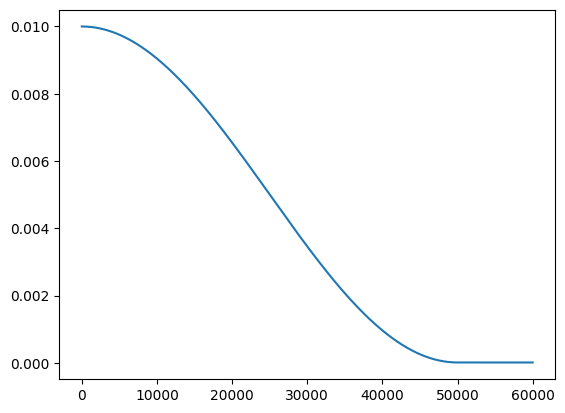

In [14]:
model = torch.nn.Linear(2, 1)
from torch.optim.lr_scheduler import SequentialLR, OneCycleLR

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = CosineAnnealingWithPlateauLR(
    optimizer, T_flat=50000, T_max=60000, eta_min=1e-5, verbose=False
)
lrs = []

for i in range(60000):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    #     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)


In [2]:
cfg = get_cfg()
add_deeplab_config(cfg)
add_config(cfg)
config_file = (
    "/home/ceballosarroyo.a/workspace/medical/cta-det2/configs/dense/dense_bn.yaml"
)
cfg.merge_from_file(config_file)

setup_data_catalog(cfg)
cfg["DATALOADER"]["NUM_WORKERS"] = 1
loader = build_test_loader_wrap(cfg)
loader_train = build_train_loader_wrap(cfg)

model = CPM_PARQ(cfg)
model.eval()
model = model.to("cuda:0")
# cfg.merge_from_list(args.opts)
cfg["DATALOADER"], cfg["DATASETS"]


Config '/home/ceballosarroyo.a/workspace/medical/cta-det2/configs/dense/dense_bn.yaml' has no VERSION. Assuming it to be compatible with latest v2.


(CfgNode({'NUM_WORKERS': 1, 'ASPECT_RATIO_GROUPING': True, 'SAMPLER_TRAIN': 'TrainingSampler', 'REPEAT_THRESHOLD': 0.0, 'FILTER_EMPTY_ANNOTATIONS': True}),
 CfgNode({'TRAIN': ('cta_train',), 'PROPOSAL_FILES_TRAIN': (), 'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000, 'TEST': ('cta_val',), 'PROPOSAL_FILES_TEST': (), 'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000}))

In [11]:
len(sample[0]["annotations"][0])


7

In [13]:
annot


array([333.5, 238.0, 682.0, 9.600000143051147, 10.80000016093254,
       8.400000125169754, 'aneurysm'], dtype=object)

In [15]:
np.mean(x_list), np.mean(y_list), np.mean(z_list)


(6.79533040954133, 5.89355829176794, 6.818900098252206)

In [14]:
z_list, x_list, y_list = [], [], []
for i, sample in enumerate(loader_train):
    annots = sample[0]["annotations"]
    for annot in annots:
        z_list.append(annot[3])
        x_list.append(annot[4])
        y_list.append(annot[5])
    if i % 20 == 0:
        print(i)
    if i == 1000:
        break


0
20
40
60
80
100
120
140
160
180
200
220


KeyboardInterrupt: 

In [13]:
from collections import OrderedDict

path_weights = "/work/vig/hieu/cta/outputs/dense_bn_64/model_0028999.pth"

# load weight dict


In [19]:
def load_pretrained_unet_weights(path, model):
    unet_weights = torch.load(path_weights, map_location=torch.device("cpu"))["model"]

    unet_keys = list(unet_weights.keys())
    remapped_unet_keys = {
        unet_key.replace("model.", ""): unet_weights[unet_key] for unet_key in unet_keys
    }
    remapped_unet_keys = OrderedDict(remapped_unet_keys)
    model_keys = list(model.state_dict().keys())
    # remove keys not in model_keys
    remapped_unet_keys = {
        model_key: remapped_unet_keys[model_key]
        for model_key in model_keys
        if model_key in remapped_unet_keys
    }
    list_keys_unet = list(remapped_unet_keys.keys())
    model.load_state_dict(remapped_unet_keys, strict=False)
    return model


model = load_pretrained_unet_weights(path_weights, model)


In [15]:
model_keys


['in_conv.conv.weight',
 'in_conv.norm.weight',
 'in_conv.norm.bias',
 'in_conv.norm.running_mean',
 'in_conv.norm.running_var',
 'in_conv.norm.num_batches_tracked',
 'in_dw.conv.weight',
 'in_dw.norm.weight',
 'in_dw.norm.bias',
 'in_dw.norm.running_mean',
 'in_dw.norm.running_var',
 'in_dw.norm.num_batches_tracked',
 'block1.conv.0.conv1.conv.weight',
 'block1.conv.0.conv1.norm.weight',
 'block1.conv.0.conv1.norm.bias',
 'block1.conv.0.conv1.norm.running_mean',
 'block1.conv.0.conv1.norm.running_var',
 'block1.conv.0.conv1.norm.num_batches_tracked',
 'block1.conv.0.conv2.conv.weight',
 'block1.conv.0.conv2.norm.weight',
 'block1.conv.0.conv2.norm.bias',
 'block1.conv.0.conv2.norm.running_mean',
 'block1.conv.0.conv2.norm.running_var',
 'block1.conv.0.conv2.norm.num_batches_tracked',
 'block1.conv.1.conv1.conv.weight',
 'block1.conv.1.conv1.norm.weight',
 'block1.conv.1.conv1.norm.bias',
 'block1.conv.1.conv1.norm.running_mean',
 'block1.conv.1.conv1.norm.running_var',
 'block1.conv.1

In [3]:
for sample in loader:
    batch = sample
    break


In [4]:
for i, sample in enumerate(loader):
    batch = sample
    if i == 0:
        break

batch[0]["image"] = batch[0]["image"][400:500, :, :]
batch[0]["image"].shape


torch.Size([100, 802, 802])

In [5]:
img = batch
model.training = False

out = model.forward(batch)


  0%|          | 0/109 [00:00<?, ?it/s]

100%|██████████| 109/109 [00:28<00:00,  3.84it/s]


torch.Size([0, 8])


In [7]:
out.shape


torch.Size([19161, 8])

In [ ]:
img = batch
output = model(img)


In [12]:
len(batch)


1

In [6]:
sample[0]["annotations"]


array([], shape=(0, 7), dtype=object)

In [ ]:
volume = sample[0]["samples"][0]["image"]


In [ ]:
slice = volume[0, :, 44, :]
slice.shape


torch.Size([96, 96])

# load from nibabel


In [ ]:
def load_image_and_label(idx):
    img_id = f"Tr{idx}.nii.gz"
    label_id = f"Tr{idx}.nii.gz"
    filename = f"/work/vig/Datasets/aneurysm/internal_train/og_0.4/{img_id}"
    label_filename = f"/work/vig/Datasets/aneurysm/internal_train/og_0.4_label/{label_id}"
    img = nib.load(filename)
    label = nib.load(label_filename)
    return img, label


def get_max_labelled_slice(volume, label_volume):
    sum_across_slices = np.sum(label_volume, axis=(0, 1))
    argmax_slice = np.argmax(sum_across_slices)
    slice = volume[:, :, argmax_slice]
    slice_label = label_volume[:, :, argmax_slice]
    return slice, slice_label


idx_a = "0014"
idx_b = "0015"

img_a, label_a = load_image_and_label(idx_a)
img_b, label_b = load_image_and_label(idx_b)


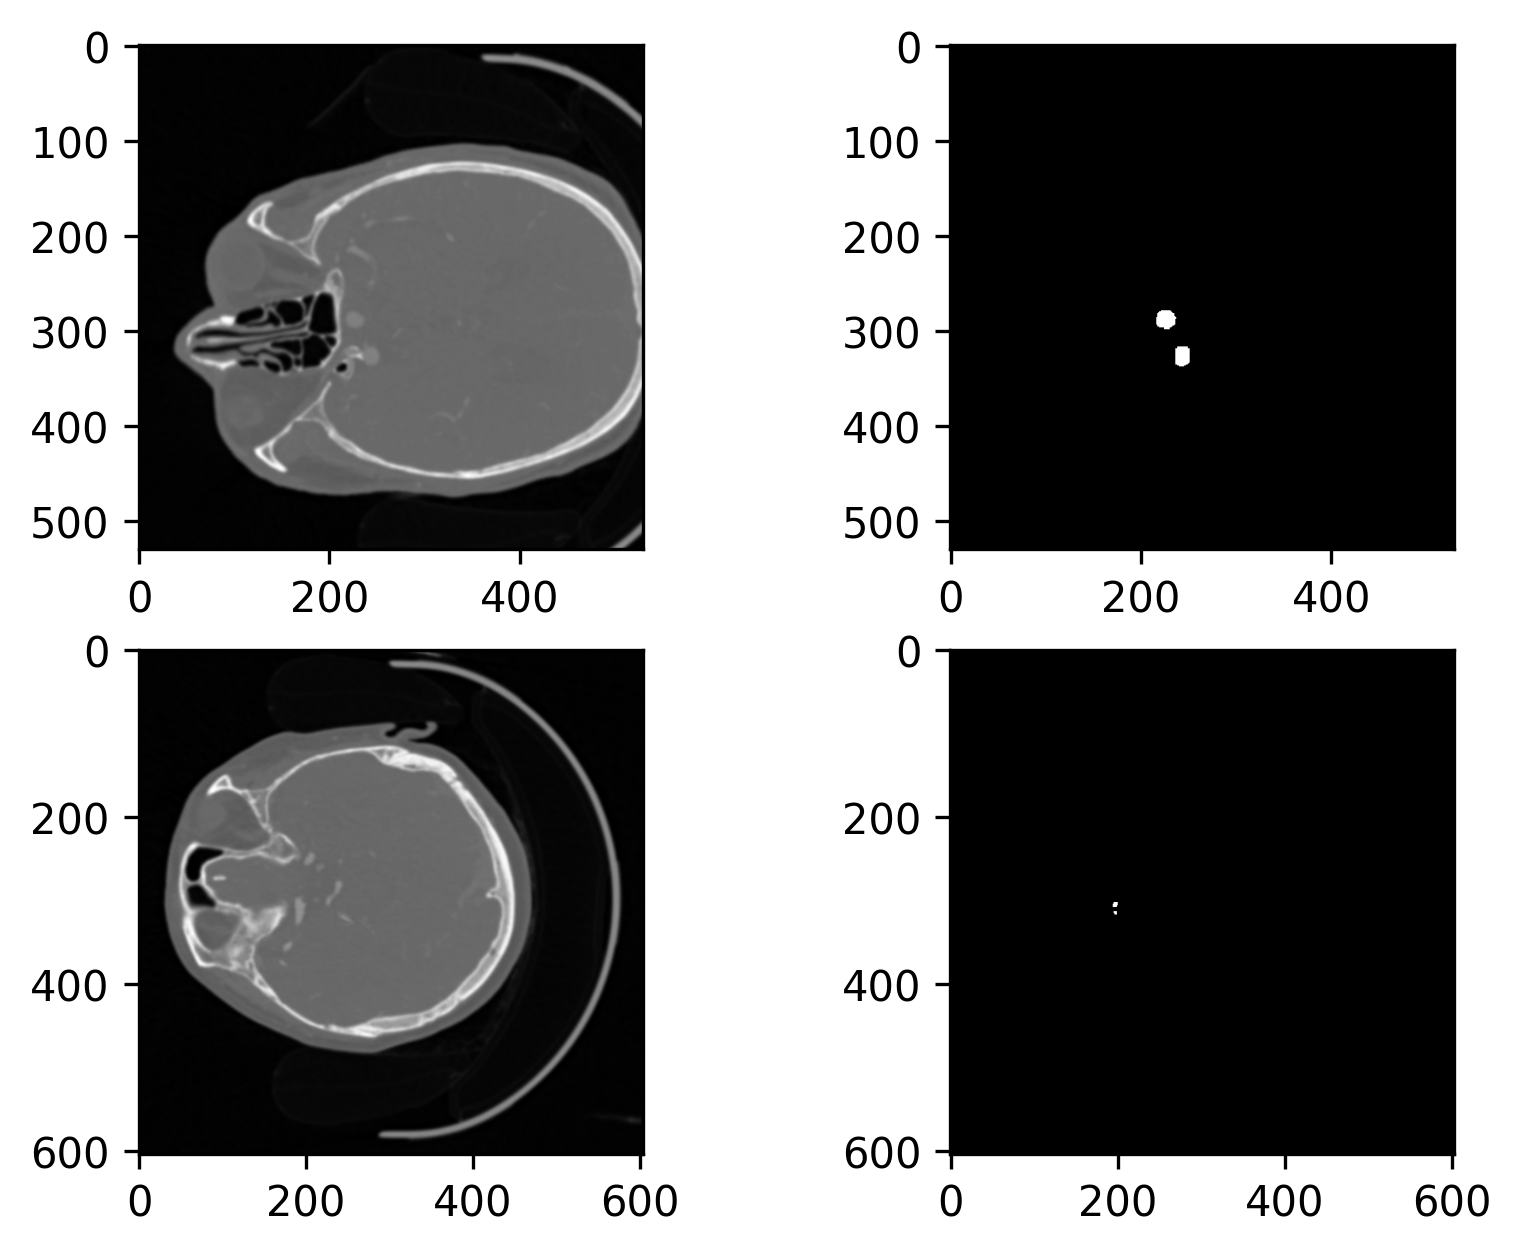

In [ ]:
volume_a = img_a.get_fdata()
label_volume_a = label_a.get_fdata()

volume_b = img_b.get_fdata()
label_volume_b = label_b.get_fdata()


volume_a = volume_a[:530, :530, :]
label_volume_a = label_volume_a[:530, :530, :]

slice_a, slice_label_a = get_max_labelled_slice(volume_a, label_volume_a)
slice_b, slice_label_b = get_max_labelled_slice(volume_b, label_volume_b)

fig, ax = plt.subplots(2, 2, dpi=300)
ax[0, 0].imshow(slice_a, cmap="gray")
ax[0, 1].imshow(slice_label_a, cmap="gray")
ax[1, 0].imshow(slice_b, cmap="gray")
ax[1, 1].imshow(slice_label_b, cmap="gray")


In [ ]:
# plt.imshow(slicey, cmap="gray")


In [ ]:
def preprocess_image(model, image):
    img_resize = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_CUBIC)
    # Resizing
    img_resize = (img_resize - img_resize.min()) / np.clip(
        img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3
    # convert the shape to (3, H, W)
    assert (
        np.max(img_resize) <= 1.0 and np.min(img_resize) >= 0.0
    ), "image should be normalized to [0, 1]"
    img_tensor = (
        torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(model.device)
    )

    return img_tensor


In [ ]:
@torch.no_grad()
def infer(model, img, bbox, img_size):
    ori_H, ori_W = img_size
    scale_to_1024 = 1024 / np.array([ori_W, ori_H, ori_W, ori_H])
    bbox_1024 = bbox * scale_to_1024
    bbox_torch = (
        torch.as_tensor(bbox_1024, dtype=torch.float).unsqueeze(0).to(model.device)
    )
    if len(bbox_torch.shape) == 2:
        bbox_torch = bbox_torch.unsqueeze(1)

    sparse_embeddings, dense_embeddings = model.prompt_encoder(
        points=None,
        boxes=bbox_torch,
        masks=None,
    )
    image_embeddings = model.image_encoder(img)
    low_res_logits, _ = model.mask_decoder(
        image_embeddings=image_embeddings,  # (B, 256, 64, 64)
        image_pe=model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=img_size,
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [ ]:
MedSAM_CKPT_PATH = (
    "/home/ceballosarroyo.a/workspace/medical/MedSAM/medsam_vit_b/medsam_vit_b.pth"
)
device = "cuda:0"
medsam_model = sam_model_registry["vit_b"](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [ ]:
slice_a_3channel = np.stack([slice_a, slice_a, slice_a], axis=2)
img_size = (slice_a.shape[0], slice_a.shape[1])
slice_a_preproc = preprocess_image(medsam_model, slice_a_3channel)


In [ ]:
bounding_box = [210, 270, 245, 305]

# slicey = slice_label_a[270:305, 210:245]


In [ ]:
output = infer(medsam_model, slice_a_preproc, bounding_box, img_size)


In [ ]:
output.shape


(530, 530)

Text(0.5, 1.0, 'MedSAM output')

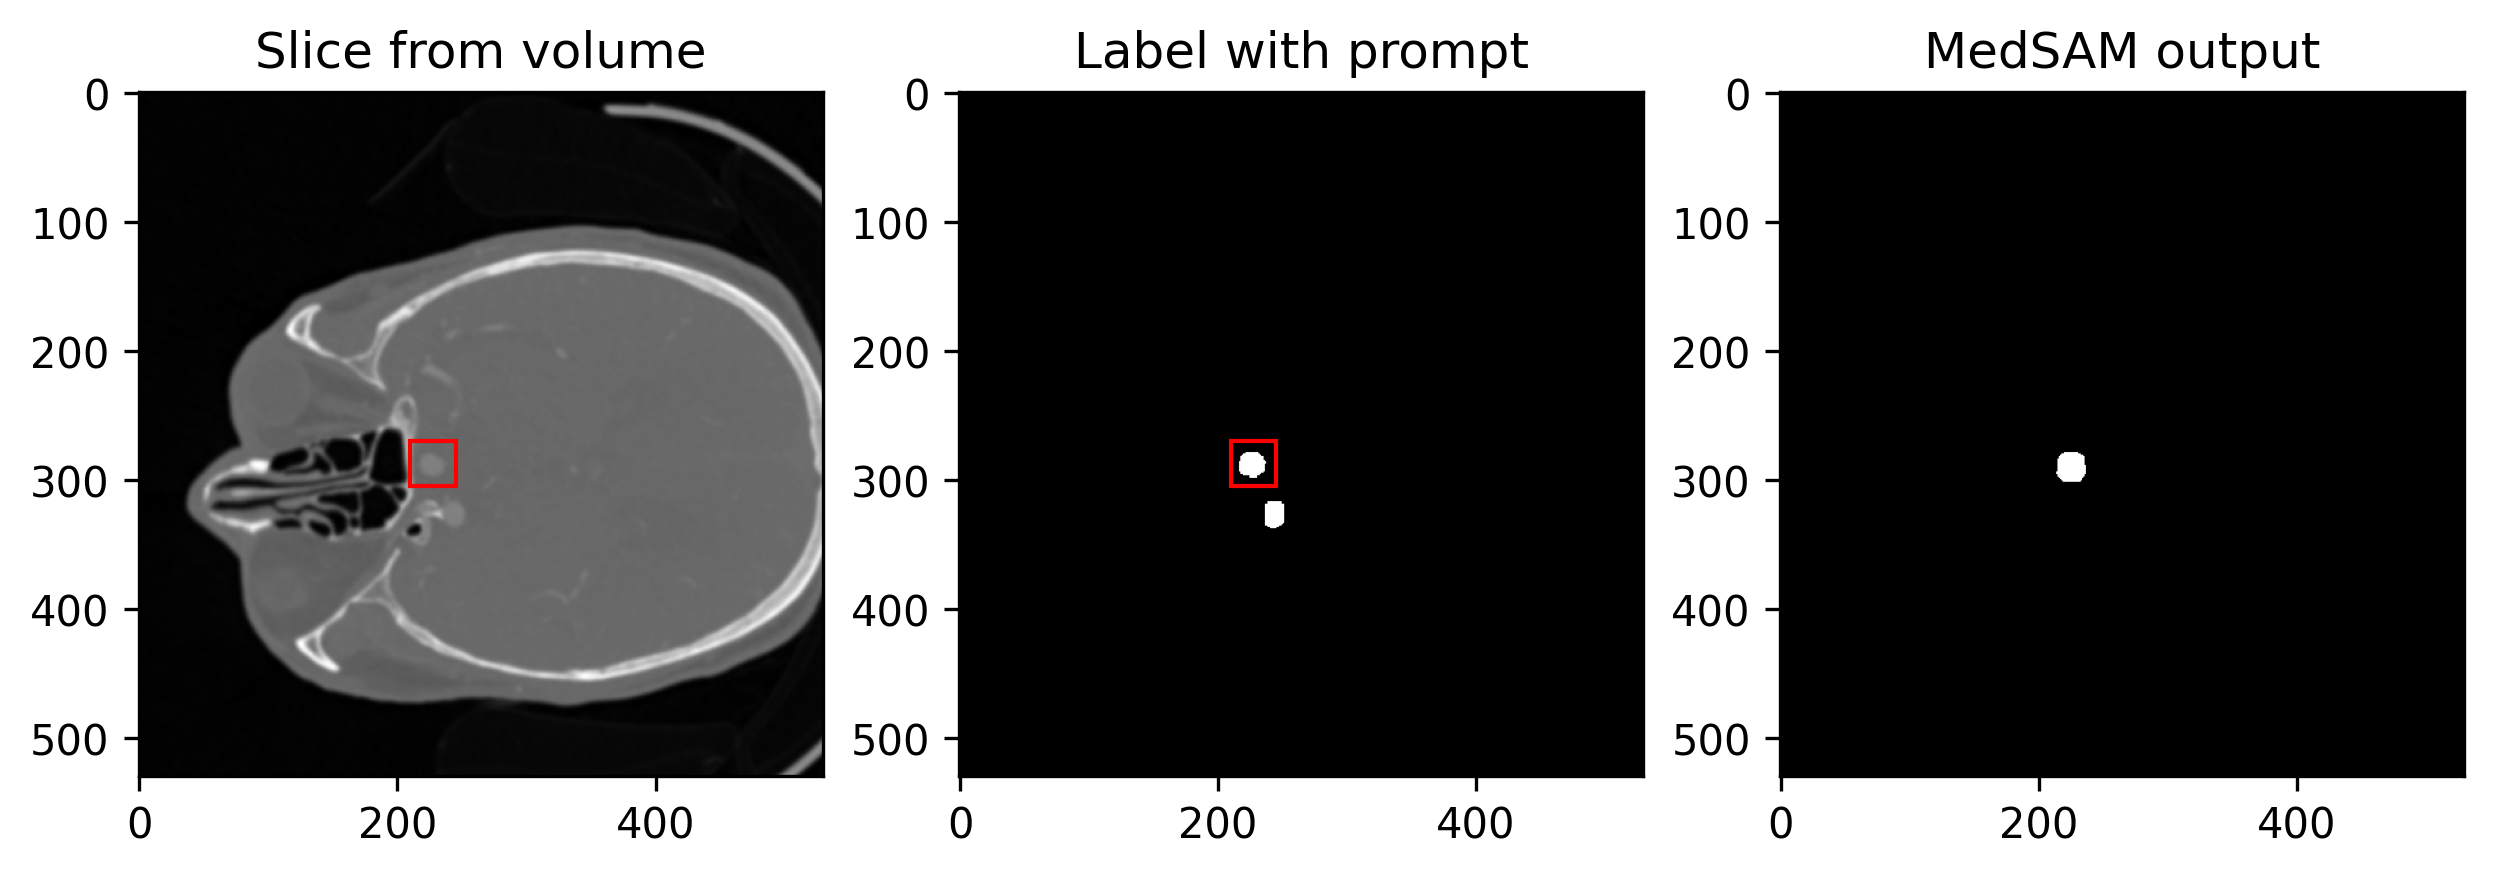

In [ ]:
fig, ax = plt.subplots(1, 3, dpi=300, figsize=(10, 10))
ax[0].imshow(slice_a, cmap="gray")
ax[1].imshow(slice_label_a, cmap="gray")
# draw rectangle based on bounding box variable
x1, y1, x2, y2 = bounding_box
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
ax[1].add_patch(rect)
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
ax[0].add_patch(rect)
ax[2].imshow(output, cmap="gray")
ax[0].set_title("Slice from volume")
ax[1].set_title("Label with prompt")
ax[2].set_title("MedSAM output")


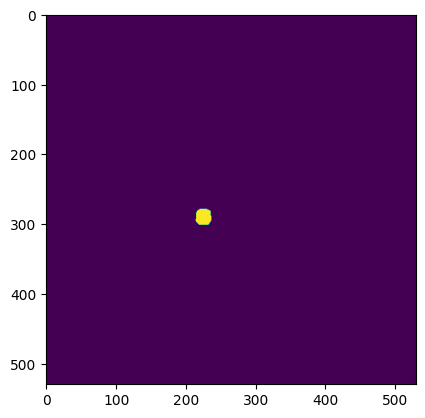

In [ ]:
plt.imshow(output)
